# Cheating at Wordle II:
## Now with memory!

Previously, we explored how entropy can be used to optimize a game of Wordle. When I originally wrote this, I failed to account for the fact that NYT Wordle does not reuse words. We could exploit this fact for even better results if we had a list of all previously played words. As it happens, I have such a list right here:

In [1]:
from setup import *
from functools import reduce
from IPython.display import display, clear_output
past_words = build_dataframe('past-word-list.csv')
past_words

""
word
motel
abhor
lathe
glare
holly
...
awake
humph
sissy


In [7]:
def remove_played(df, past_words):
    remaining = df.merge(past_words.drop_duplicates(), on=['word'], 
                   how='left', indicator=True)
    return remaining.loc[remaining['_merge'] == 'left_only'].drop('_merge', axis=1)

def remove_word(word, df, filename=None):
    remaining = df.loc[df.index != word]
    if filename:
        remaining.to_csv(filename)
    return remaining

full = build_dataframe('word-list.txt')
df = remove_played(full, past_words)

In [8]:
def simulate2(df, strategy, target=None, memory=False, verbose=False):
    _df = df.copy()
    if not target:
        target = df.sample(n=1).index[0]
    if verbose:
        print("Target word:", target, "Remaining words:", len(df))
    guesses = []
    result = ""
    
    while True:
        """
        Last time, we always played the word 'irate' first because it had the highest entropy out of the original 
        2309 words (which I've since found more, bringing the total corpus up to 2333 words).  With memory, we can't
        assume that 'irate' will highest have the highest entropy (in fact, it was already played, so it doesn't even
        appear in our corpus with memory applied).
        """
        if strategy == Strategy.ENTROPIC and len(guesses) == 0 and memory is False:
            guess = 'irate'
            guesses.append('irate')
        elif strategy == Strategy.RANDOM:
            guess = _df.sample(n=1).index[0]
            guesses.append(guess)
        else:
            scores = score_remaining_words(_df, show_entropy=False)
            guess = scores.index[0]
            score = scores['score'].values[0]
            guesses.append(guess)
        result = check_word(target, guess)
        _df = update(_df, guess, result)
        if verbose:
            print(guess, result, score)
        if result == "XXXXX":
            break
    return remove_word(target, df), { # Tabular data is best data
        "target": target,
        "guess_count": len(guesses),
        "memory": memory,
        "strategy": strategy
    }

"""
We have to change how run the experiment so that we are continually shrinking the the corpus as words are selected when using memory
"""
def collect_data(df: pd.DataFrame, wordlist: pd.DataFrame, strategy: Strategy, memory=True):
    _df = df.copy()
    results = []
    total_size = len(wordlist)
    remaining = total_size
    for word in wordlist:
        remaining -= 1
        clear_output(wait=True)
        display(f"Running {strategy} simulations with Memory={memory}...{round((1.0 - remaining/total_size) * 100, 2)}%")
        updated_df, result = simulate2(_df, strategy=strategy, target=word, memory=memory)
        results.append(result)
        if memory:
            _df = updated_df # This removes the last target word from the guess list on the next pass, so it should improve over time.
    return results
    

In [ ]:
wordlist = list(df.sample(n=len(df)).index)
mem_t_ent_t = collect_data(df, wordlist, Strategy.ENTROPIC)
mem_f_ent_t = collect_data(full, wordlist, Strategy.ENTROPIC, memory=False)
mem_t_ent_f = collect_data(df, wordlist, Strategy.RANDOM)
mem_f_ent_f = collect_data(full, wordlist, Strategy.RANDOM, memory=False)

In [137]:
df1 = pd.DataFrame(mem_t_ent_t)
df2 = pd.DataFrame(mem_f_ent_t)
df3 = pd.DataFrame(mem_t_ent_f)
df4 = pd.DataFrame(mem_f_ent_f)

In [85]:
# Save everything since that took a while.
df1.to_csv("mem_t_ent_t.csv")
df2.to_csv("mem_f_ent_t.csv")
df3.to_csv("mem_t_ent_f.csv")
df4.to_csv("mem_f_ent_f.csv")

In [4]:
df1 = pd.read_csv("mem_t_ent_t.csv")
df2 = pd.read_csv("mem_f_ent_t.csv")
df3 = pd.read_csv("mem_t_ent_f.csv")
df4 = pd.read_csv("mem_f_ent_f.csv")

,target,guess_count,memory,strategy
0,basil,2,True,Strategy.ENTROPIC
1,eying,4,True,Strategy.ENTROPIC
2,clink,4,True,Strategy.ENTROPIC
3,twixt,4,True,Strategy.ENTROPIC
4,posse,3,True,Strategy.ENTROPIC
...,...,...,...,...
732,parse,2,True,Strategy.ENTROPIC
733,mucus,2,True,Strategy.ENTROPIC
734,basal,2,True,Strategy.ENTROPIC
735,tatty,2,True,Strategy.ENTROPIC


In [5]:
df1['ent_with_mem'] = df1.guess_count
df2['ent_without_mem'] = df2.guess_count
df3['rand_with_mem'] = df3.guess_count
df4['rand_without_mem'] = df4.guess_count

def cleanup(df):
    df.drop(columns=['guess_count', 'strategy', 'memory'], inplace=True)

cleanup(df1)
cleanup(df2)
cleanup(df3)
cleanup(df4)

<Axes: title={'center': '50 day moving average # of guesses'}>

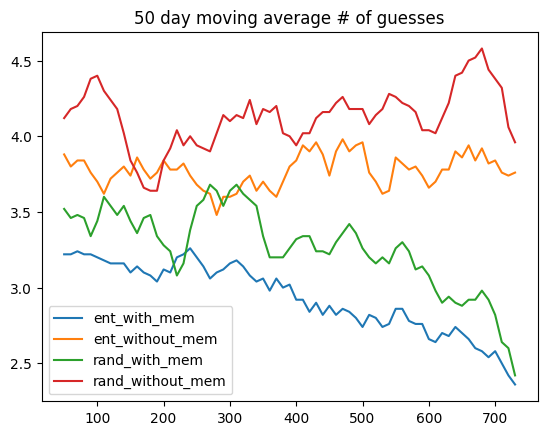

In [9]:
# pd.concat([df1, df2, df3, df4], axis=1, join='inner', on='target')[['target']]
combined = df1.merge(df2, on='target').merge(df3, on='target').merge(df4, on='target')

combined.drop(columns=['target']).rolling(window=50, step=10, method='single').mean().plot.line(title="50 day moving average # of guesses")